# Generate Generative Model Figures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
from collections import OrderedDict
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import seaborn as sns
import pdb
import scipy.stats as ss

In [2]:
def get_dataframes(
    result_dir, file_path,
    starting_point=0,
    ending_point=30,
    step=5, num_of_points=4
):
    """
     This function grabs the result tsv files
     and loads then into a dictionary strucutre
     [relationship] -> dataframe

     Args:
         result_dir - the directory containing all the results
         file_path - the path to extract the result files
         starting_point - the point to start each subgraph with in plot_graph function
         ending_point - the point to end each subgraph with
         step - the number to increase the middle points with
         num_of_points - the number of points to plot between the start and end points
    """
    # Build up X axis by gathering relatively evely spaced points
    query_points = [starting_point]
    query_points += [1 + step*index for index in range(num_of_points)]
    query_points += [ending_point]

    return {
        # Get the head word of each file that will be parsed
        os.path.splitext(os.path.basename(file))[0].split("_")[0]:
        pd.read_csv(file, sep="\t")
        .query("lf_num in @query_points", engine="python", local_dict={"query_points":query_points})
        .assign(
            lf_num=lambda x:x['lf_num'].map(lambda y: str(y) if y != ending_point else 'All')
        )
        for file in glob.glob(f"{result_dir}/{file_path}")
    }

In [3]:
file_tree = OrderedDict({
        "DaG":
        {
            "DaG": "../../../disease_gene/disease_associates_gene/label_sampling_experiment/results/DaG/results",
            "CtD": "../../../disease_gene/disease_associates_gene/label_sampling_experiment/results/CtD/results",
            "CbG": "../../../disease_gene/disease_associates_gene/label_sampling_experiment/results/CbG/results",
            "GiG": "../../../disease_gene/disease_associates_gene/label_sampling_experiment/results/GiG/results",
            "All": "../../../disease_gene/disease_associates_gene/label_sampling_experiment/results/all/results",
        },
        "CtD":
        {
            "DaG": "../../../compound_disease/compound_treats_disease/label_sampling_experiment/results/DaG/results",
            "CtD": "../../../compound_disease/compound_treats_disease/label_sampling_experiment/results/CtD/results",
            "CbG": "../../../compound_disease/compound_treats_disease/label_sampling_experiment/results/CbG/results",
            "GiG": "../../../compound_disease/compound_treats_disease/label_sampling_experiment/results/GiG/results",
            "All": "../../../compound_disease/compound_treats_disease/label_sampling_experiment/results/all/results",
        },

        "CbG":
        {
            "DaG": "../../../compound_gene/compound_binds_gene/label_sampling_experiment/results/DaG/results",
            "CtD": "../../../compound_gene/compound_binds_gene/label_sampling_experiment/results/CtD/results",
            "CbG": "../../../compound_gene/compound_binds_gene/label_sampling_experiment/results/CbG/results",
            "GiG": "../../../compound_gene/compound_binds_gene/label_sampling_experiment/results/GiG/results",
            "All": "../../../compound_gene/compound_binds_gene/label_sampling_experiment/results/all/results",
        },
        "GiG":
        {
            "DaG": "../../../gene_gene/gene_interacts_gene/label_sampling_experiment/results/DaG/results",
            "CtD": "../../../gene_gene/gene_interacts_gene/label_sampling_experiment/results/CtD/results",
            "CbG": "../../../gene_gene/gene_interacts_gene/label_sampling_experiment/results/CbG/results",
            "GiG": "../../../gene_gene/gene_interacts_gene/label_sampling_experiment/results/GiG/results",
            "All": "../../../gene_gene/gene_interacts_gene/label_sampling_experiment/results/all/results",
        }
    })

In [4]:
# End total of label functions for each point
end_points = {
    "DaG": 30,
    "CtD": 22,
    "CbG": 20,
    "GiG": 28,
    "All": 100
}

In [5]:
critical_val = ss.norm.ppf(0.975)

In [6]:
color_names = {
        "turquoise": pd.np.array([27, 158, 119, 255])/255,
        "orange": pd.np.array([217, 95, 2, 255])/255,
        "purple": pd.np.array([117, 112, 179, 255])/255,
        "pink": pd.np.array([231, 41, 138, 255])/255,
        "light-green": pd.np.array([102, 166, 30, 255])/255
    }

In [7]:
color_map = {
        "DaG": color_names["turquoise"],
        "CtD": color_names["orange"],
        "CbG": color_names["purple"],
        "GiG": color_names["pink"],
        "All": color_names["light-green"]
}

In [8]:
# Use the file tree above and graph the appropiate files
performance_data_tree = OrderedDict({
    key: {
        sub_key: get_dataframes(
            file_tree[key][sub_key], "*sampled_results.tsv",
            ending_point=end_points[sub_key],
            # if using all the label functions step by 32 instead of 5
            step=5 if sub_key != "All" else 32
        )
        for sub_key in file_tree[key]
    }
    for key in file_tree
})

In [9]:
dev_performance_df = pd.DataFrame([], columns=['aupr', 'auroc', 'lf_num', 'predicted', 'lf_source'])
test_performance_df = pd.DataFrame([], columns=['aupr', 'auroc', 'lf_num', 'predicted', 'lf_source'])
for predicted in performance_data_tree:
    for source in performance_data_tree[predicted]:
        for dataset in performance_data_tree[predicted][source]:
            if dataset == 'dev':
                dev_performance_df = dev_performance_df.append(
                    (
                        performance_data_tree[predicted][source][dataset]
                        [["aupr", "auroc", "lf_num"]]
                        .assign(**{
                            'predicted':predicted,
                            'lf_source':source
                        })
                    )   
                )
            else:
                test_performance_df = test_performance_df.append(
                    (
                        performance_data_tree[predicted][source][dataset]
                        [["aupr", "auroc", "lf_num"]]
                        .assign(**{
                            'predicted':predicted,
                            'lf_source':source
                        })
                    )   
                )

In [10]:
dev_performance_df = (
    dev_performance_df
    .groupby(["lf_num", "predicted","lf_source"])
    .agg({
        "auroc": ['mean', 'std'],
        "aupr": ['mean', 'std'],
        "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
dev_performance_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in dev_performance_df.columns.values
]

dev_performance_df = (
    dev_performance_df
    .assign(**{
        'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_lower': lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
    })
)

dev_performance_df.head(2)

,lf_num,predicted,lf_source,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,CbG,All,0.621242,0.0,0.159903,0.0,1,0.621242,0.621242,0.159903,0.159903
1,0,CbG,CbG,0.621242,0.0,0.159903,0.0,1,0.621242,0.621242,0.159903,0.159903


In [11]:
test_performance_df = (
    test_performance_df
    .groupby(["lf_num", "predicted","lf_source"])
    .agg({
        "auroc": ['mean', 'std'],
        "aupr": ['mean', 'std'],
        "lf_num": len
    })
    .reset_index()
    .fillna(0)
)
test_performance_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in test_performance_df.columns.values
]


test_performance_df = (
    test_performance_df
    .assign(**{
        'auroc_upper': lambda x: x.auroc_mean + (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'auroc_lower': lambda x: x.auroc_mean - (critical_val * x.auroc_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_upper': lambda x: x.aupr_mean + (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len),
        'aupr_lower': lambda x: x.aupr_mean - (critical_val * x.aupr_std)/pd.np.sqrt(x.lf_num_len)
    })
)

test_performance_df.head(2)

,lf_num,predicted,lf_source,auroc_mean,auroc_std,aupr_mean,aupr_std,lf_num_len,auroc_upper,auroc_lower,aupr_upper,aupr_lower
0,0,CbG,All,0.781794,0.0,0.290519,0.0,1,0.781794,0.781794,0.290519,0.290519
1,0,CbG,CbG,0.781794,0.0,0.290519,0.0,1,0.781794,0.781794,0.290519,0.290519


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


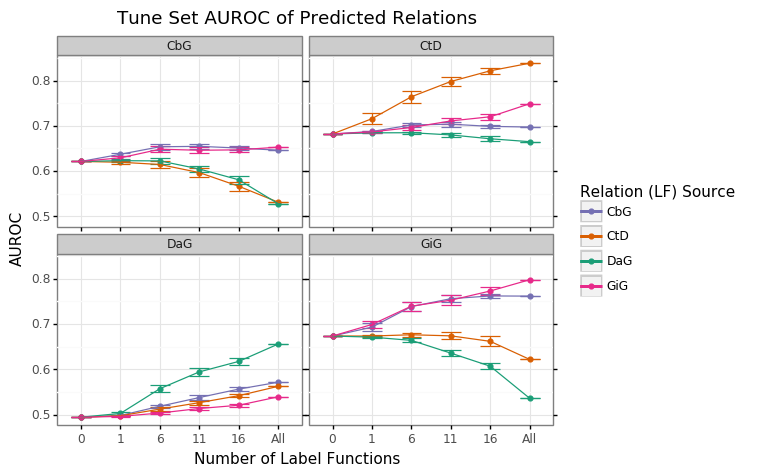

<ggplot: (-9223363300699431883)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../transfer_dev_set_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pa

In [12]:
g = (
    p9.ggplot(
        dev_performance_df.query("lf_source != 'All'"), 
        p9.aes(x="factor(lf_num)", y="auroc_mean", color="lf_source")
    )
    + p9.scale_x_discrete(limits=['0', '1', '6', '11', '16', 'All'])
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Tune Set AUROC of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
)
print(g)
g.save(filename="../transfer_dev_set_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


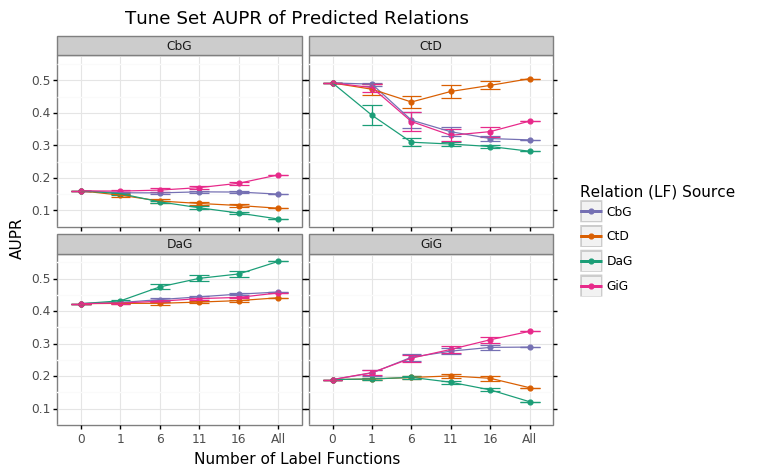

<ggplot: (8736146736069)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../transfer_dev_set_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pac

In [13]:
g = (
    p9.ggplot(
        dev_performance_df.query("lf_source != 'All'"), 
        p9.aes(x="factor(lf_num)", y="aupr_mean", color="lf_source")
    )
    + p9.scale_x_discrete(limits=['0', '1', '6', '11', '16', 'All'])
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Tune Set AUPR of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
)
print(g)
g.save(filename="../transfer_dev_set_aupr.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


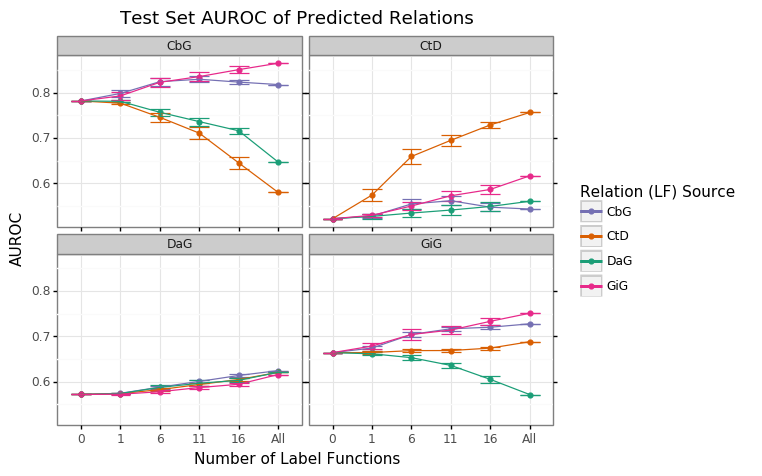

<ggplot: (-9223363300708617570)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../transfer_test_set_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-p

In [14]:
g = (
    p9.ggplot(
        test_performance_df.query("lf_source != 'All'"),
        p9.aes(x="factor(lf_num)", y="auroc_mean", color="lf_source")
    )
    + p9.scale_x_discrete(limits=['0', '1', '6', '11', '16', 'All'])
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Test Set AUROC of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
)
print(g)
g.save(filename="../transfer_test_set_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


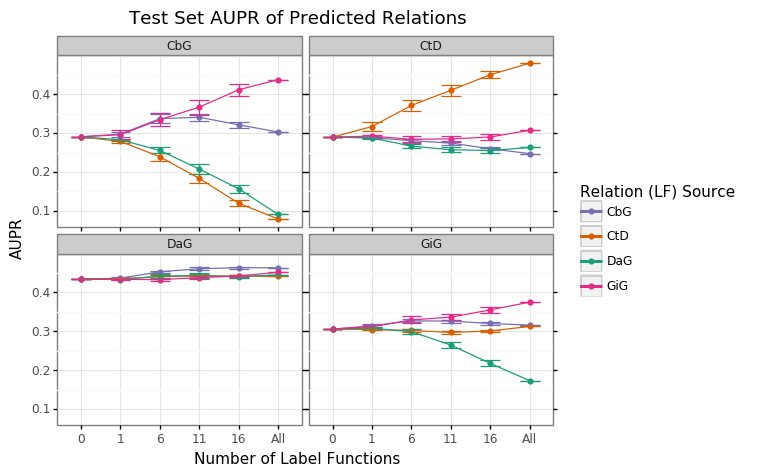

<ggplot: (-9223363300707949971)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../transfer_test_set_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pa

In [15]:
g = (
    p9.ggplot(
        test_performance_df.query("lf_source != 'All'"),
        p9.aes(x="factor(lf_num)", y="aupr_mean", color="lf_source")
    )
    + p9.scale_x_discrete(limits=['0', '1', '6', '11', '16', 'All'])
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Test Set AUPR of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
)
print(g)
g.save(filename="../transfer_test_set_aupr.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


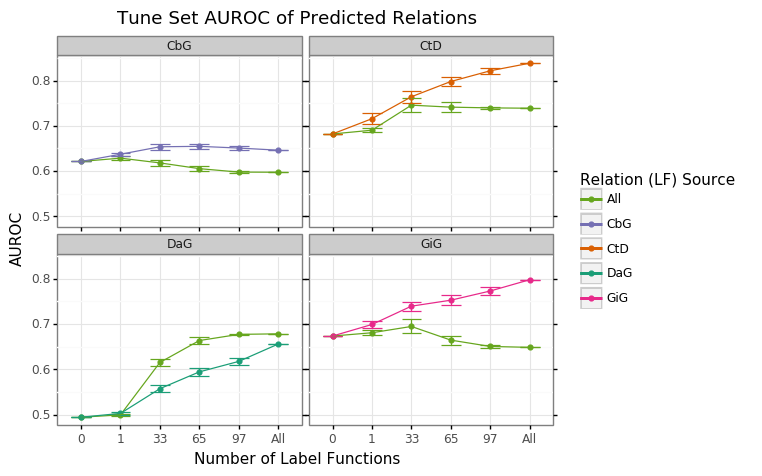

<ggplot: (-9223363300699418701)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../all_lf_dev_set_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pack

In [16]:
g = (
    p9.ggplot(
        dev_performance_df.query("lf_source==predicted|lf_source=='All'").replace({'6':'33', '11': '65', '16':'97'}),
        p9.aes(x="factor(lf_num)", y="auroc_mean", color="lf_source")
    )
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        "All": mcolors.to_hex(color_map["All"])
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Tune Set AUROC of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
)
print(g)
g.save(filename="../all_lf_dev_set_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


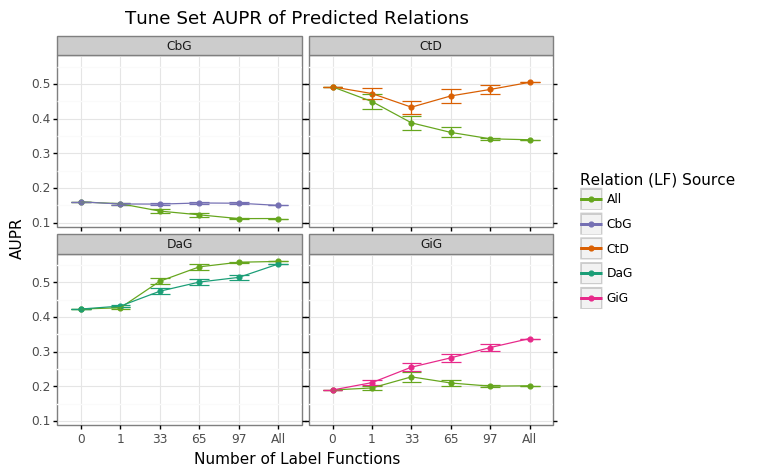

<ggplot: (-9223363300708996664)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../all_lf_dev_set_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packa

In [17]:
g = (
    p9.ggplot(
        dev_performance_df.query("lf_source==predicted|lf_source=='All'").replace({'6':'33', '11': '65', '16':'97'}),
        p9.aes(x="factor(lf_num)", y="aupr_mean", color="lf_source")
    )
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        "All": mcolors.to_hex(color_map["All"])
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Tune Set AUPR of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
)
print(g)
g.save(filename="../all_lf_dev_set_aupr.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


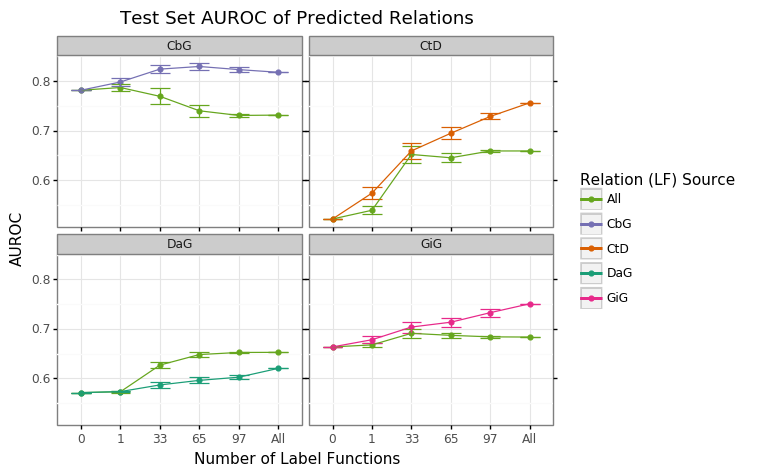

<ggplot: (8736146151474)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../all_lf_test_set_auroc.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pac

In [18]:
g = (
    p9.ggplot(
        test_performance_df.query("lf_source==predicted|lf_source=='All'").replace({'6':'33', '11': '65', '16':'97'}),
        p9.aes(x="factor(lf_num)", y="auroc_mean", color="lf_source")
    )
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="auroc_lower", ymax="auroc_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        "All": mcolors.to_hex(color_map["All"])
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Test Set AUROC of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUROC")
)
print(g)
g.save(filename="../all_lf_test_set_auroc.png", dpi=300)

/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


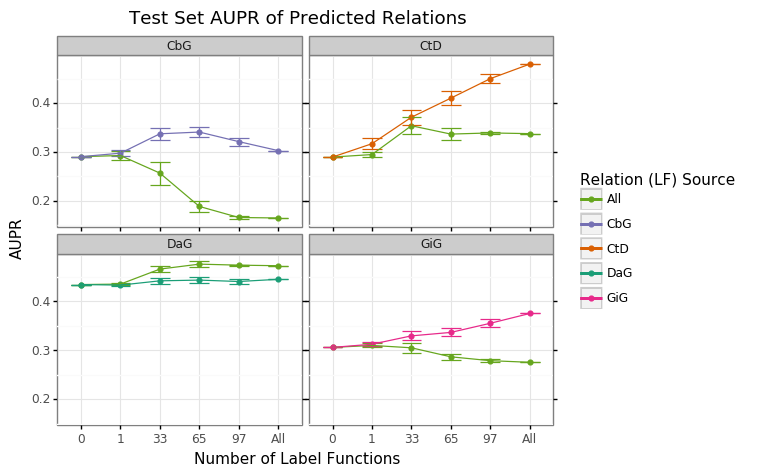

<ggplot: (8736152796799)>


/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../all_lf_test_set_aupr.png
  warn('Filename: {}'.format(filename))
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/home/danich1/anaconda3/envs/snorkeling/lib/python3.6/site-pack

In [19]:
g = (
    p9.ggplot(
        test_performance_df.query("lf_source==predicted|lf_source=='All'").replace({'6':'33', '11': '65', '16':'97'}),
        p9.aes(x="factor(lf_num)", y="aupr_mean", color="lf_source")
    )
    + p9.geom_point()
    + p9.geom_errorbar(p9.aes(ymin="aupr_lower", ymax="aupr_upper"))
    + p9.geom_line(p9.aes(x="factor(lf_num)", group="lf_source"))
    + p9.scale_color_manual(values={
        "DaG": mcolors.to_hex(color_map["DaG"]),
        'CtD': mcolors.to_hex(color_map["CtD"]),
        "CbG": mcolors.to_hex(color_map["CbG"]),
        "GiG": mcolors.to_hex(color_map["GiG"]),
        "All": mcolors.to_hex(color_map["All"])
        })
    + p9.facet_wrap("predicted")
    + p9.theme(figure_size=(12,8), aspect_ratio=4)
    + p9.theme_bw()
    + p9.labs(
        title="Test Set AUPR of Predicted Relations",
        color="Relation (LF) Source"
    )
    + p9.xlab("Number of Label Functions")
    + p9.ylab("AUPR")
)
print(g)
g.save(filename="../all_lf_test_set_aupr.png", dpi=300)

# Old All Grid

In [20]:
def plot_individual_grid(
    dataframe=None,
    metric="",
    title="",
    file_name="",
    color_map=None
):
    """
    Plot the graphs onto a multi-subplot grid using seaborn
    Args:
        metric - the metric to plot for the y axis {auroc_mean, aupr_mean}
        title - the main title of the large graph
        file_name - the name of the file to save the graph
        color_map - the color coded to plot each point on
    """
    
    fig, axes = plt.subplots(
        len(dev_performance_df.predicted.unique()), 
        len(dev_performance_df.lf_source.unique()),
        figsize=(25, 15), sharey='row'
    )

    for pred_idx, predicted in enumerate(dataframe.predicted.unique()):
        for lf_source_idx, lf_source in enumerate(dataframe.lf_source.unique()):
            temp_df = dataframe.query(f"predicted=='{predicted}'&lf_source=='{lf_source}'")
            if lf_source == 'All':
                sns.pointplot(
                        x="lf_num", y=f"{metric}",
                        data=(
                            temp_df
                            .astype({
                                "lf_num":pd.api.types.CategoricalDtype(
                                    categories=['0', '1', '33', '65', '97', 'All'], 
                                    ordered=True
                                )
                            })
                        ),
                        ax=axes[pred_idx][lf_source_idx],
                        scale=1.25
                    )
            else:
                sns.pointplot(
                        x="lf_num", y=f"{metric}",
                        data=(
                            temp_df
                            .astype({
                                "lf_num":pd.api.types.CategoricalDtype(
                                    categories=['0', '1', '6', '11', '16', 'All'], 
                                    ordered=True
                                )
                            })
                        ),
                        ax=axes[pred_idx][lf_source_idx],
                        scale=1.25
                    )

            # remove x axis labels
            axes[pred_idx][lf_source_idx].set_xlabel('')
            if metric == "auroc_mean":
                axes[pred_idx][lf_source_idx].set_ylim([0.45, 1])

            if metric == "aupr_mean":
                axes[pred_idx][lf_source_idx].set_ylim([0, 0.6])

            for idx, item in enumerate(axes[pred_idx][lf_source_idx].get_children()):

                    # if the points in graph
                    # change color map accordingly
                    if idx == 0:
                        item.set_edgecolor([
                            color_map[predicted] if index==0 else color_map[lf_source] 
                            for index in range(len(temp_df.lf_num.unique()))
                        ])
                        item.set_facecolor([
                            color_map[predicted] if index==0 else color_map[lf_source] 
                            for index in range(len(temp_df.lf_num.unique()))
                        ])

                    #if error bars change accordingly
                    elif isinstance(item, plt.Line2D):
                        if idx == 1:
                            #item.set_linestyle('dashed')
                            item.set_color("black")

                        else:
                            item.set_color(color_map[lf_source])

            # only set first column and first row titles
            if pred_idx == 0:
                axes[pred_idx][lf_source_idx].set_title(lf_source, color=color_map[lf_source])

            if lf_source_idx == 0:
                axes[pred_idx][lf_source_idx].set_ylabel(predicted, color=color_map[predicted])
            else:
                axes[pred_idx][lf_source_idx].set_ylabel('')

        # Change the font for each element of the graph
        for item in axes.flat:
            item.title.set_fontsize(30)
            item.yaxis.label.set_fontsize(25)
            item.xaxis.label.set_fontsize(25)
            for tick in item.get_yticklabels() + item.get_xticklabels():
                tick.set_fontsize(23)

        # Add the subtitles and save the graph
        fig.text(0.5, 0.89, 'Label Function Sources', ha='center', fontsize=26)
        fig.text(0.5, 0.04, 'Number of Additional Label Functions', ha='center', fontsize=30)
        fig.text(0.04, 0.5, f'Predicted Relations ({metric[:metric.find("_")]})', va='center', rotation='vertical', fontsize=25)
        fig.suptitle(title, fontsize=30)
        fig.text(0.69, 0.02, '0-Only Uses Relation Specific Databases.', fontsize=27)
        plt.subplots_adjust(top=0.85)
        plt.savefig(file_name, format='png')

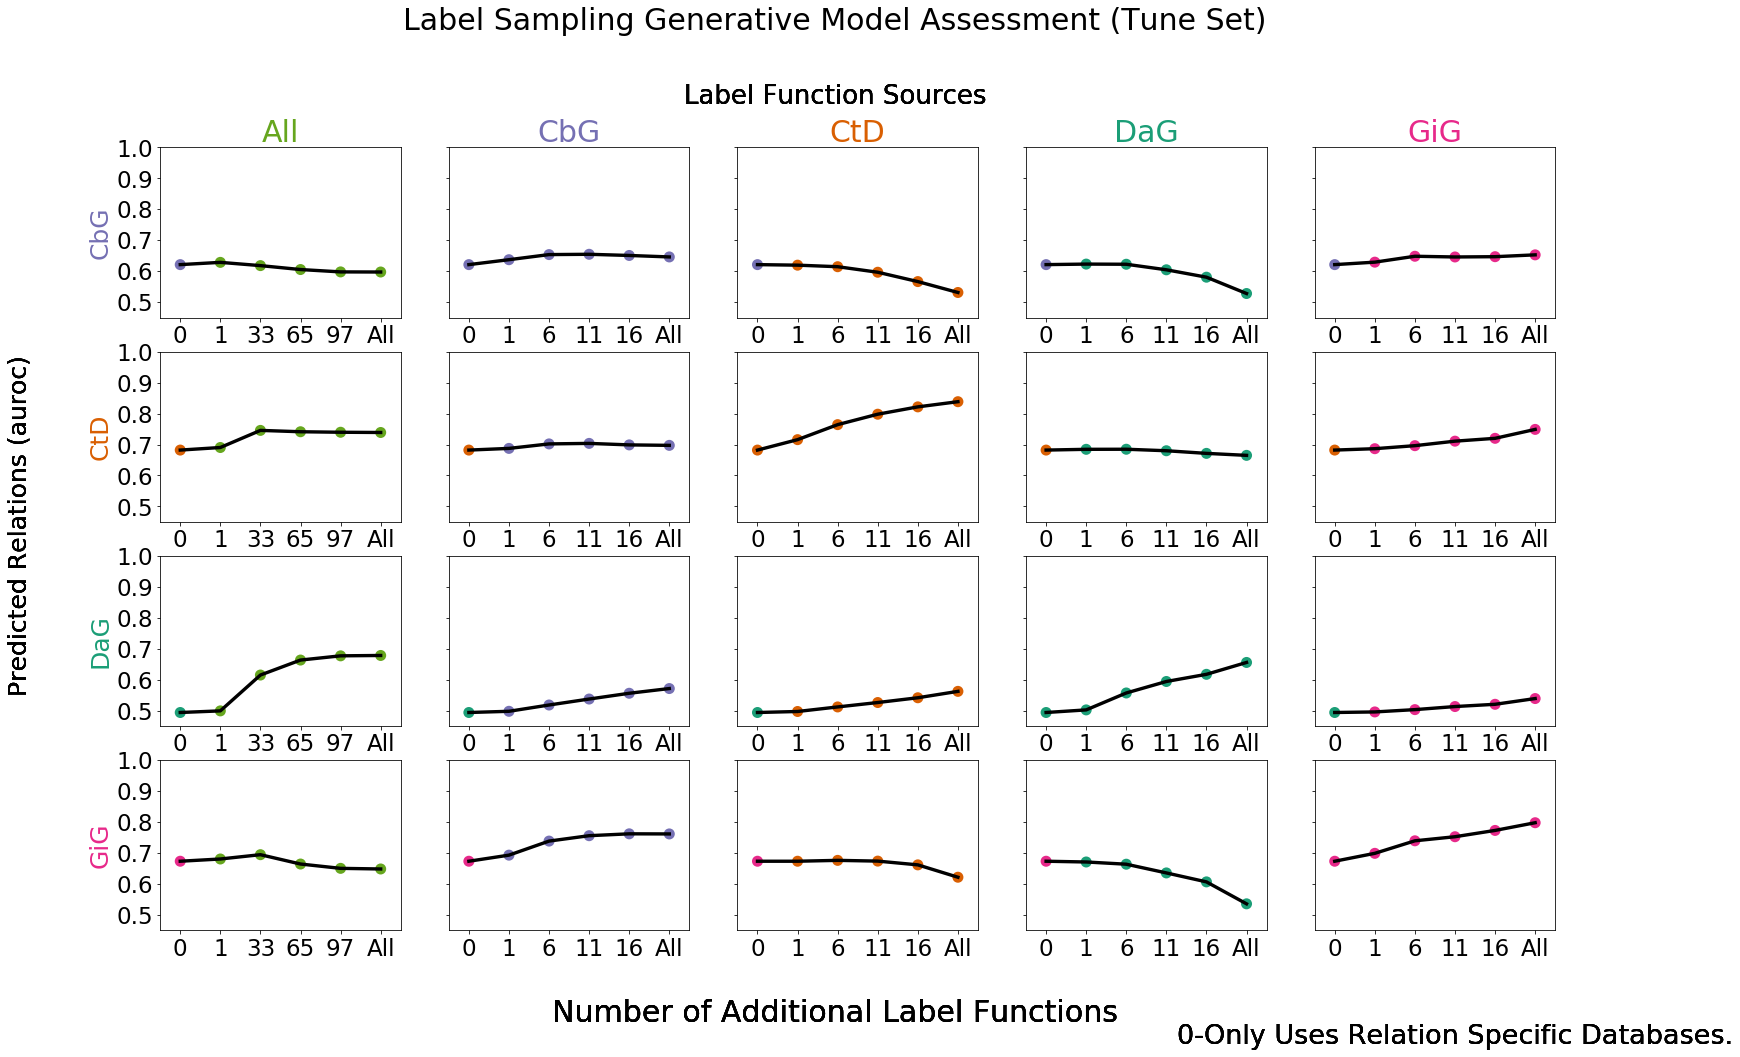

In [21]:
plot_individual_grid(
    dataframe=dev_performance_df, 
    metric="auroc_mean", 
    title="Label Sampling Generative Model Assessment (Tune Set)", 
    file_name="../indiv_grid_dev_set_auroc.png",
    color_map=color_map
)

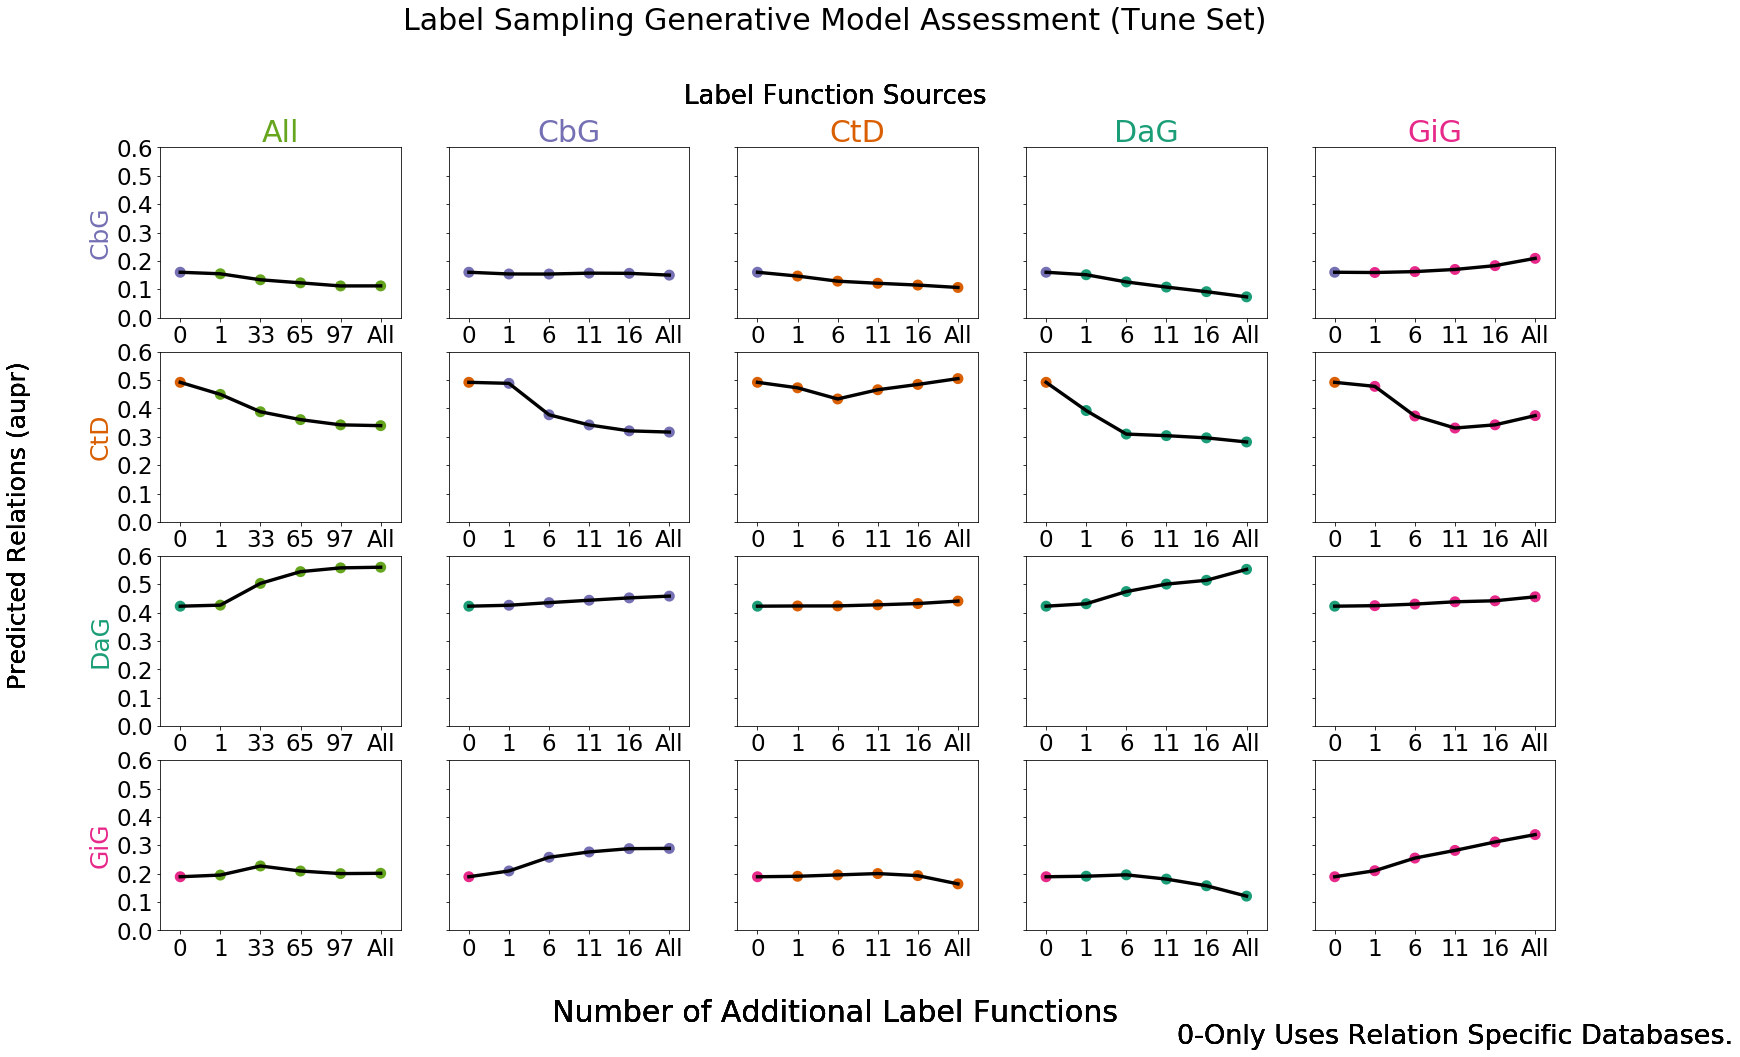

In [22]:
plot_individual_grid(
    dataframe=dev_performance_df, 
    metric="aupr_mean", 
    title="Label Sampling Generative Model Assessment (Tune Set)", 
    file_name="../indiv_grid_dev_set_aupr.png",
    color_map=color_map
)

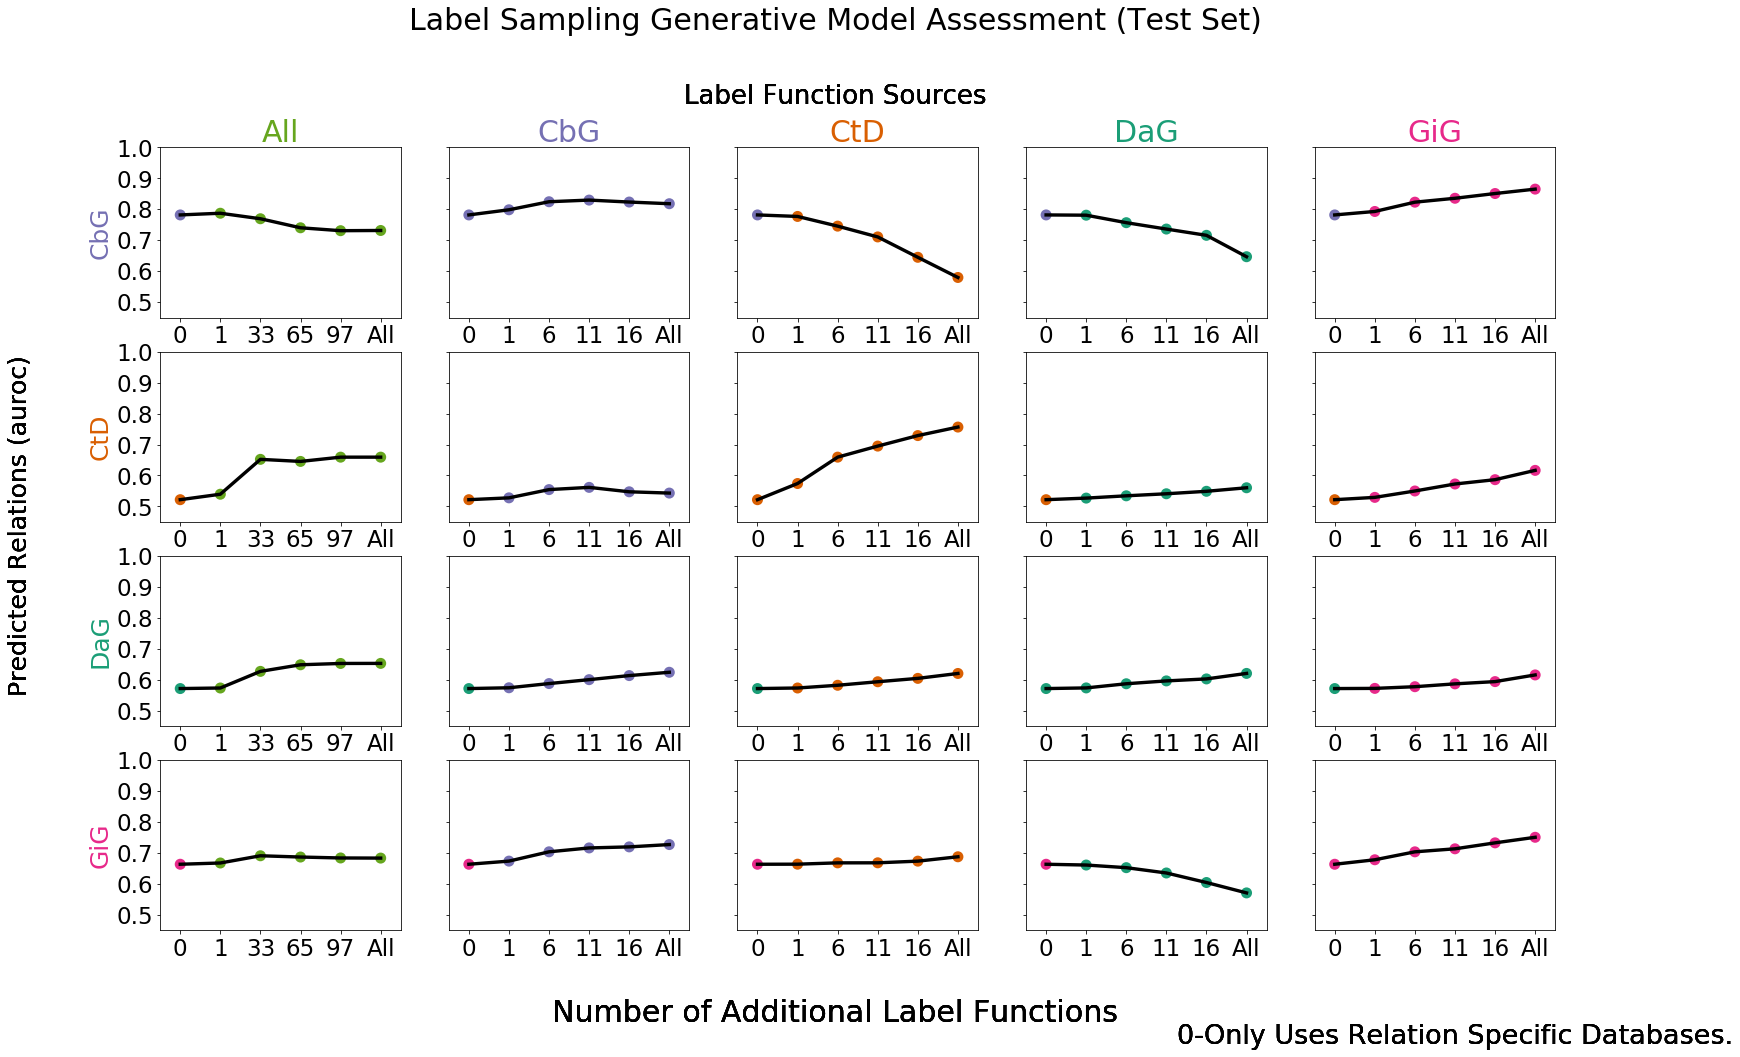

In [23]:
plot_individual_grid(
    dataframe=test_performance_df, 
    metric="auroc_mean", 
    title="Label Sampling Generative Model Assessment (Test Set)", 
    file_name="../indiv_grid_test_set_auroc.png",
    color_map=color_map
)

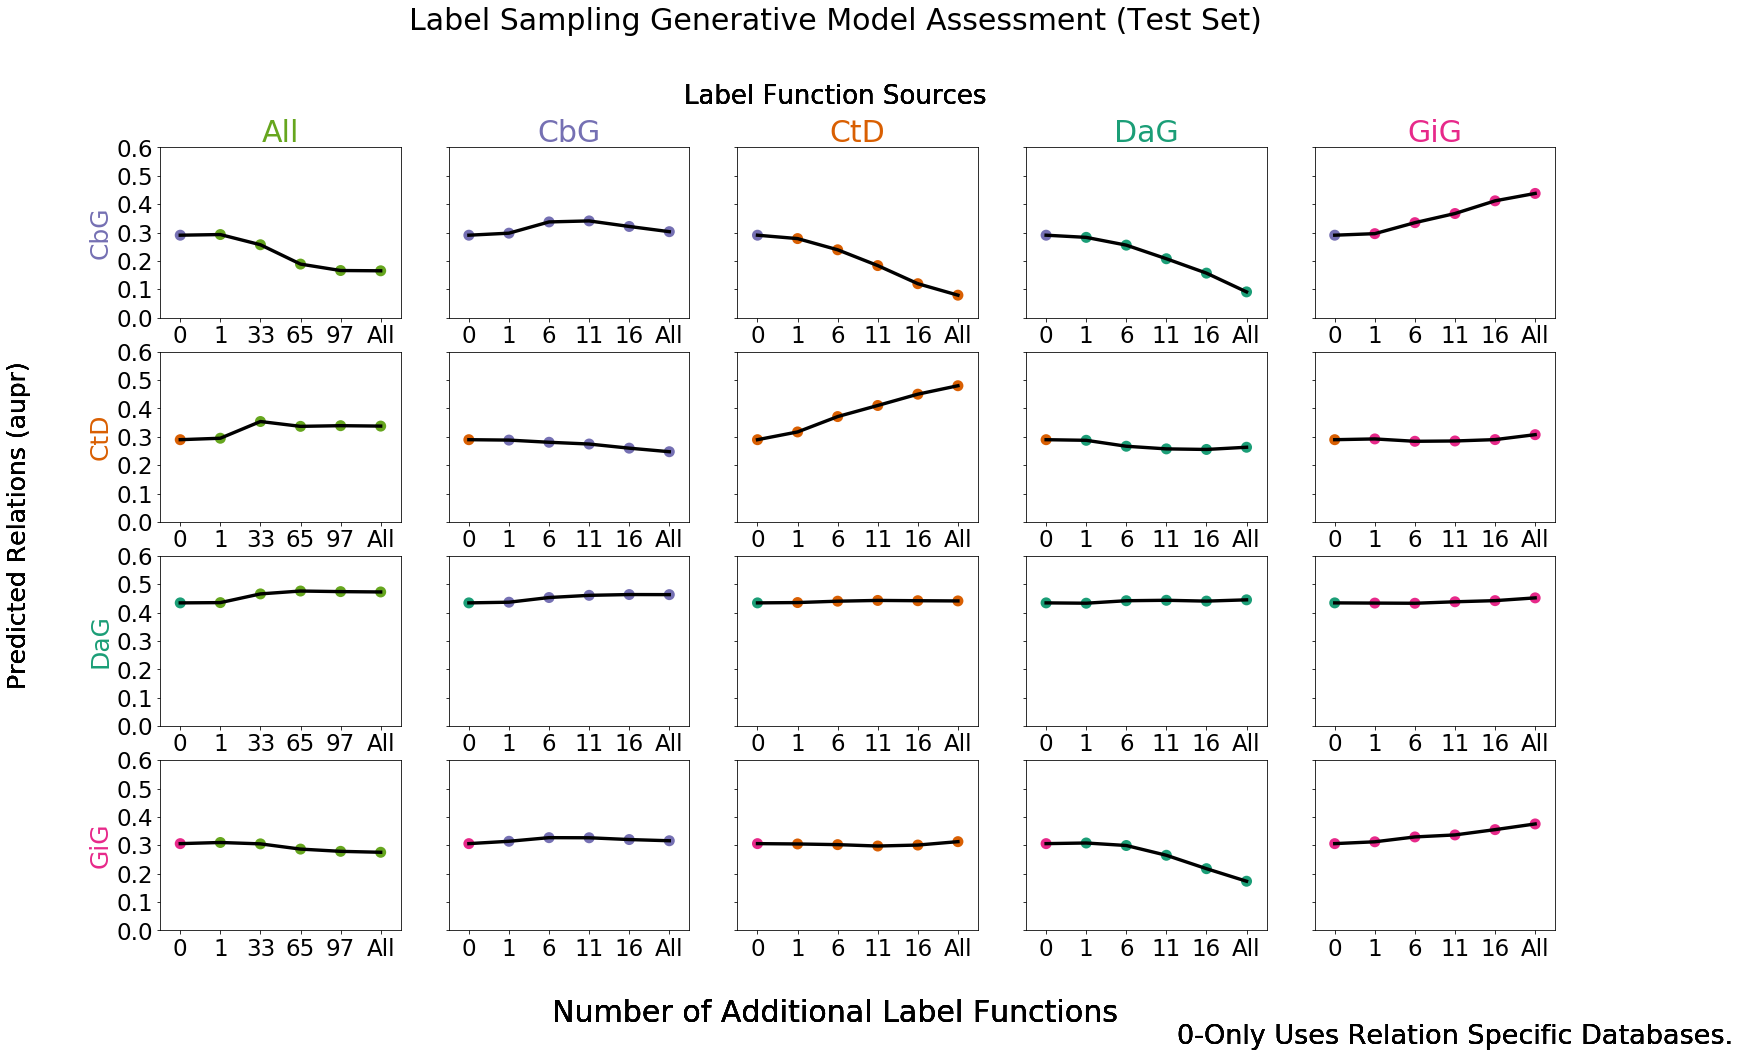

In [24]:
plot_individual_grid(
    dataframe=test_performance_df, 
    metric="aupr_mean", 
    title="Label Sampling Generative Model Assessment (Test Set)", 
    file_name="../indiv_grid_test_set_aupr.png",
    color_map=color_map
)